In [1]:
import numpy as np
import pandas as pd
import jpx_tokyo_market_prediction
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load data

In [2]:
prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv")

In [3]:
prices.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263
1,20211206_1332,2021-12-06,1332,592.0,599.0,588.0,589.0,1360800,1.0,NaN,False,-0.008993
2,20211206_1333,2021-12-06,1333,2368.0,2388.0,2360.0,2377.0,125900,1.0,NaN,False,-0.009963
3,20211206_1375,2021-12-06,1375,1230.0,1239.0,1224.0,1224.0,81100,1.0,NaN,False,-0.015032
4,20211206_1376,2021-12-06,1376,1339.0,1372.0,1339.0,1351.0,6200,1.0,NaN,False,0.002867


In [4]:
prices.describe()

,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target
count,112000.000000,111716.000000,111716.000000,111716.000000,111716.000000,1.120000e+05,112000.000000,503.000000,112000.000000
mean,5883.054000,2684.313035,2717.101250,2645.627351,2680.175912,5.995511e+05,0.999940,23.385308,-0.001071
std,2389.818157,4257.855565,4308.294164,4196.004142,4249.675941,2.289323e+06,0.005678,32.305817,0.023810
min,1301.000000,35.000000,36.000000,34.000000,34.000000,0.000000e+00,0.333333,0.000000,-0.355000
25%,3915.750000,1025.000000,1039.000000,1012.000000,1025.000000,3.190000e+04,1.000000,0.000000,-0.012329
50%,6200.500000,1813.000000,1837.000000,1788.000000,1811.000000,9.690000e+04,1.000000,15.000000,-0.000478
75%,7938.250000,2985.000000,3015.000000,2943.000000,2982.000000,3.668000e+05,1.000000,30.000000,0.010388
max,9997.000000,79030.000000,79250.000000,78600.000000,79080.000000,1.177263e+08,1.000000,297.000000,0.597907


In [5]:
prices.isnull().sum()

RowId                    0
Date                     0
SecuritiesCode           0
Open                   284
High                   284
Low                    284
Close                  284
Volume                   0
AdjustmentFactor         0
ExpectedDividend    111497
SupervisionFlag          0
Target                   0
dtype: int64

In [6]:
average = pd.DataFrame(prices.groupby("SecuritiesCode").Target.mean())
def get_avg(_id_):
    return average.loc[_id_]
prices["Avg"] = prices["SecuritiesCode"].apply(get_avg)

# Train the model

In [7]:
prices.Date = pd.to_datetime(prices.Date)
prices['Date'] = prices['Date'].dt.strftime("%Y%m%d").astype(int)
X=prices[["Date","SecuritiesCode","Avg"]]
y=prices[["Target"]]
codes = X.SecuritiesCode.unique()

In [8]:
model=LGBMRegressor(num_leaves=500, learning_rate=0.05, n_estimators=100)
model.fit(X,y)
model.score(X,y)

0.4420931170001925

# Let's take a look at our predictions

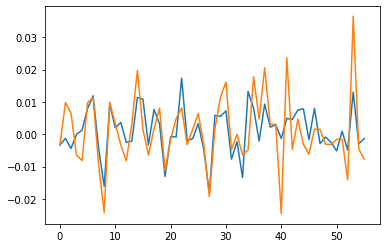

In [9]:
plt.plot(model.predict(X[X.SecuritiesCode == 1301]))
plt.plot(np.array(prices[prices.SecuritiesCode == 1301].Target))

# Submission

In [10]:
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    ds=[prices, options, financials, trades, secondary_prices, sample_prediction]
    sample_prediction["Avg"] = sample_prediction["SecuritiesCode"].apply(get_avg)
    df = sample_prediction[["Date","SecuritiesCode","Avg"]]
    df.Date = pd.to_datetime(df.Date)
    df['Date'] = df['Date'].dt.strftime("%Y%m%d").astype(int)
    sample_prediction["Prediction"] = model.predict(df)
    sample_prediction = sample_prediction.sort_values(by = "Prediction", ascending=False)
    sample_prediction.Rank = np.arange(0,2000)
    sample_prediction = sample_prediction.sort_values(by = "SecuritiesCode", ascending=True)
    sample_prediction.drop(["Prediction"],axis=1)
    submission = sample_prediction[["Date","SecuritiesCode","Rank"]]
    env.predict(submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
